## 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import TFElectraModel
from transformers import ElectraTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
strategy = tf.distribute.get_strategy()

## 1. Load Dataset

In [3]:
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

task = "nli"
datasets = load_dataset("klue", task)

Reusing dataset klue (C:\Users\Home\.cache\huggingface\datasets\klue\nli\1.0.0\e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
train_premise = datasets["train"]["premise"]
train_hypothesis = datasets["train"]["hypothesis"]
train_label = datasets["train"]["label"]

test_premise = datasets["validation"]["premise"]
test_hypothesis = datasets["validation"]["hypothesis"]
test_label = datasets["validation"]["label"]

In [5]:
train = pd.DataFrame({"premise":train_premise,
                         "hypothesis":train_hypothesis,
                         "label":train_label})
test = pd.DataFrame({"premise":test_premise,
                         "hypothesis":test_hypothesis,
                         "label":test_label})

In [6]:
train.head()

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,0
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,2
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,1
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,1
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,2


In [7]:
test.head()

,premise,hypothesis,label
0,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,어떤 방에서도 흡연은 금지됩니다.,2
1,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기 불편함이 많았다.,2
2,10명이 함께 사용하기 불편함없이 만족했다.,성인 10명이 함께 사용하기 불편함없이 없었다.,1
3,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기에 만족스러웠다.,0
4,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,건물사람들은 수영장과 썬베드를 이용할 수 있습니다.,0


In [8]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (24998, 3) 
test shape => (3000, 3)


## 2. EDA

### 2.1. 결측치 제거

In [9]:
train.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

In [10]:
# 결측값가 존재한다면, 결측값 제거
# train.dropna(inplace=True)

### 2.3. 클래스 불균형 확인

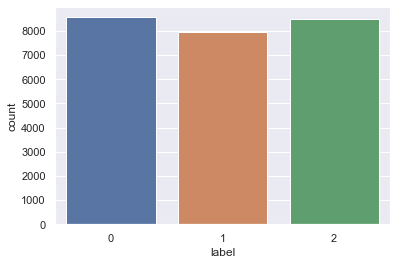

In [11]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

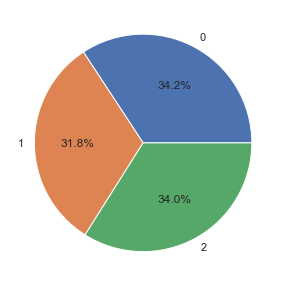

In [12]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3. Modeling

### 3.1. 토크나이저 선언

In [13]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

### 3.2. 훈련 데이터 전처리

훈련데이터에 대해 각 문장에 대한 인코딩을 수행하고 패딩을 맞춰주는 전처리 작업을 진행합니다.  
토크나이징이 진행된 문장들에 대해 평균, 최대, 표준편차, 시각화를 통해 적절한 패딩 길이를 계산합니다.  
그 이후, 훈련데이터를 8:2 비율로 훈련데이터와 검증데이터를 나눕니다.  

#### 패딩 적절 길이 구하기

In [14]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [15]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)
test_encoded_electra = tokenizer.batch_encode_plus(test_data)

In [16]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 40.567969140652906
토큰 길이 최대: 98
토큰 길이 표준편차: 13.617052076270076


In [17]:
test_num_tokens_electra = [len(tokens) for tokens in test_encoded_electra['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_electra)}")

토큰 길이 최대: 88


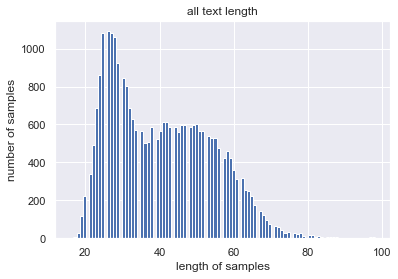

In [18]:
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
select_length = 90

In [20]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 90 이하인 샘플의 비율: 0.9993928137724123


#### 길이가 90 이상인 데이터 삭제

In [22]:
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train.drop(train.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_electra['input_ids'])):
    if len(test_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

In [23]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [24]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)
test_encoded_electra = tokenizer.batch_encode_plus(test_data)

In [25]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

In [26]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 90 이하인 샘플의 비율: 1.0


In [27]:
len(train_data)

24981

In [28]:
len(test_data)

3000

최종 예측을 진행할 테스트 데이터에서 측정된 최대 토큰 길이는 98입니다.  
테스트 데이터는 삭제하면 안되기 때문에, 패딩 길이는 88이상이어야 합니다.  
따라서, 패딩 길이를 90으로 설정하고, 90 이하인 데이터에 대해 삭제를 진행했습니다.  

### 3.3. ELECTRA Modeling

In [29]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=90)
test_encoded_electra = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=90)

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.label.values, test_size=0.3, random_state=777)
x_test = test_encoded_electra['input_ids']

In [31]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [32]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(90,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

모델을 로딩하는 아래 코드에 대해 "OSError: [WinError 127] 지정된 프로시저를 찾을 수 없습니다. Error loading"  
발생 시, PyTorch 버전을 1.5.1 이하로 재설치하면 해결 가능.

In [33]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'electra.embeddings.position_ids']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 90)]              0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutput(last_hi 112330752 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 112,333,059
Trainable params: 112,333,059
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                  validation_data=valid_dataset,epochs= 3)

Epoch 1/3
1249/1249 [==============================] - 246s 191ms/step - loss: 0.5050 - accuracy: 0.7904 - val_loss: 0.3960 - val_accuracy: 0.8687
Epoch 2/3
1249/1249 [==============================] - 239s 191ms/step - loss: 0.2219 - accuracy: 0.9201 - val_loss: 0.4044 - val_accuracy: 0.8787
Epoch 3/3
1249/1249 [==============================] - 238s 190ms/step - loss: 0.1105 - accuracy: 0.9639 - val_loss: 0.4823 - val_accuracy: 0.8777


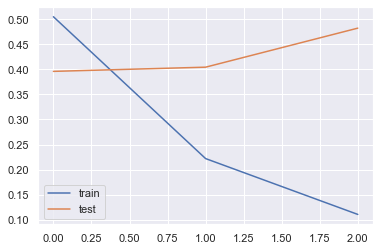

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
pred = model.predict(test_dataset, verbose=1)
pred_arg = pred.argmax(axis=1)

150/150 [==============================] - 8s 47ms/step


In [38]:
len(pred_arg)

3000

In [39]:
pred_arg

array([2, 2, 1, ..., 0, 1, 0], dtype=int64)

## 4. Result

In [40]:
accuracy_score(test['label'], pred_arg)

0.856